In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import scipy.stats as stats
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import missingno as msno
import os
import wget
import openpyxl
import math

from scipy.stats import stats

In [2]:
df = pd.read_csv('gva_mass_shootings-2025-10-21.csv')
df

,incident_id,incident_date,incident_time,updated_date,state,city_or_county,address,business_location_name,latitude,longitude,...,injured,victims_killed,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics,sources,date_fixed,year
0,809048,"April 1, 2017",NaN,1491348530,Florida,Tampa,219 S Howard Ave,Palace Lounge,27.9431,-82.4831,...,4,1,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://wfla.com/2017/04/01/tampa-police-inv...",2017-04-01,2017
1,809499,"April 1, 2017",5:25 AM,1680156402,Oklahoma,Oklahoma City,1212 N Woodward Ave,NaN,35.4810,-97.5754,...,3,2,3,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.news9.com/story/35055747/okc-pol...",2017-04-01,2017
2,809815,"April 1, 2017",NaN,1492995601,California,Pittsburg,100 block of Madoline Street,NaN,38.0053,-121.8950,...,5,0,5,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.nbcbayarea.com/news/local/Shooting-...,2017-04-01,2017
3,1082835,"April 1, 2018",2:15 AM,1522693801,Michigan,Saginaw,600 block of Yale St,NaN,43.4192,-83.9819,...,5,0,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.mlive.com/news/saginaw/index.ssf/20...,2018-04-01,2018
4,1083011,"April 1, 2018",NaN,1646889853,Alabama,Mobile,3556 Halls Mill Rd,Grand Hall,30.6387,-88.1228,...,4,1,4,0,0,3,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.al.com/news/mobile/index.ssf/201...",2018-04-01,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,2411007,"September 9, 2022",4:50 PM,1722738993,New York,Bronx,810 Astor Ave,Pelham Parkway Houses,40.8592,-73.8634,...,4,0,4,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...","c(""https://twitter.com/NYC_Alerts911/status/15...",2022-09-09,2022
5464,2411901,"September 9, 2022",11:50 PM,1689272621,Minnesota,Minneapolis,328 W Broadway Ave,4th Street Saloon,44.9994,-93.2848,...,3,1,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""https://www.fox9.com/news/2-pregnant-women-...",2022-09-09,2022
5465,2410446,"September 9, 2022",9:00 AM,1715920831,Maryland,Elk Mills,47 Hebron Ct,NaN,39.6611,-75.8365,...,0,4,0,1,0,0,"Shot - Dead (murder, accidental, or suicide), ...","c(""https://www.cbsnews.com/baltimore/news/five...",2022-09-09,2022
5466,2703975,"September 9, 2023",11:30 PM,1694472936,South Carolina,Rock Hill,800 block of Brunswick Dr,NaN,34.8921,-81.0411,...,4,0,4,0,0,2,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",https://www.heraldonline.com/news/local/crime/...,2023-09-09,2023


In [3]:
# Add csv for gini coefficient by yearSplit first row by ;, and unify column names to lowercase with underscores
df2 = pd.read_csv("gini.csv", sep=';')
df2 = df2.rename(columns={'Unnamed: 3': 'gini_coefficient'})
df2.columns = [c.lower().replace(' ', '_') for c in df2.columns]

# Updating name of DC to match in both dataframes
df2['state'].replace({"Dist. of Columbia": "District of Columbia"}, inplace=True)

# Merging dataframes on year and state
df_merged = pd.merge(left = df, right = df2, left_on=['year', 'state'], right_on=['year', 'state'], how='left')

# Deleting unnecessary index column from right dataframe
del df_merged['unnamed:_0']

# Clean gini_coefficient column by multiplying numbers above 1 by 0.001 (Gini coefficient should be between 0 and 1)
df_merged['gini_coefficient'] = df_merged['gini_coefficient'].apply(lambda x: x * 0.001 if x > 1 else x)

# Getting the mean gini coefficient by state
df_gini_mean = df_merged.groupby('state')['gini_coefficient'].mean()

# Updating all states missing gini coefficient with the mean gini coefficient of that state
for state in df_gini_mean.index:
    mean_gini = df_gini_mean[state]
    df_merged["gini_coefficient"].fillna(value=mean_gini, inplace=True)

# Adding link of Wikipedia page for poverty in each state, and preparing for web scraping
url = "https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_poverty_rate#cite_note-CensusData-1"
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content)
table = soup.find("tbody")

# Defining labels for dataframe:
labels = [label.get_text() for label in table.find_all("a")]

# Getting values for dataframe:
values = table.find_all("td")
list_values = values[1:len(values):5]
for values in list_values:
    value = float(values.get_text().replace("\n",""))


# Iterating through labels and values to create a dataframe
poverty_data = {}
for key, value in zip(labels, list_values):
    poverty_data[key] = value

# Create dataframe for poverty levels in different states
df_poverty = pd.DataFrame.from_dict(poverty_data, orient='index', columns=['poverty_rate_2025'])

# Updating states with column for poverty rates in states in 2025 and making the poverty rate a float
df_merged = pd.merge(left=df_merged, right=df_poverty, left_on='state', right_index=True, how='left')
df_merged['poverty_rate_2025'] = df_merged['poverty_rate_2025'].astype(float)
df_merged

/var/folders/wc/048rx86x7bqbzmjn7nr46j_80000gn/T/ipykernel_6924/1849478275.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df2['state'].replace({"Dist. of Columbia": "District of Columbia"}, inplace=True)
/var/folders/wc/048rx86x7bqbzmjn7nr46j_80000gn/T/ipykernel_6924/1849478275.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

,incident_id,incident_date,incident_time,updated_date,state,city_or_county,address,business_location_name,latitude,longitude,...,victims_injured,suspects_killed,suspects_injured,suspects_arrested,incident_characteristics,sources,date_fixed,year,gini_coefficient,poverty_rate_2025
0,809048,"April 1, 2017",NaN,1491348530,Florida,Tampa,219 S Howard Ave,Palace Lounge,27.9431,-82.4831,...,4,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://wfla.com/2017/04/01/tampa-police-inv...",2017-04-01,2017,0.4859,12.3
1,809499,"April 1, 2017",5:25 AM,1680156402,Oklahoma,Oklahoma City,1212 N Woodward Ave,NaN,35.4810,-97.5754,...,3,0,0,1,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.news9.com/story/35055747/okc-pol...",2017-04-01,2017,0.4658,15.9
2,809815,"April 1, 2017",NaN,1492995601,California,Pittsburg,100 block of Madoline Street,NaN,38.0053,-121.8950,...,5,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.nbcbayarea.com/news/local/Shooting-...,2017-04-01,2017,0.4866,12.0
3,1082835,"April 1, 2018",2:15 AM,1522693801,Michigan,Saginaw,600 block of Yale St,NaN,43.4192,-83.9819,...,5,0,0,0,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",http://www.mlive.com/news/saginaw/index.ssf/20...,2018-04-01,2018,0.4679,13.5
4,1083011,"April 1, 2018",NaN,1646889853,Alabama,Mobile,3556 Halls Mill Rd,Grand Hall,30.6387,-88.1228,...,4,0,0,3,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""http://www.al.com/news/mobile/index.ssf/201...",2018-04-01,2018,0.4859,15.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5463,2411007,"September 9, 2022",4:50 PM,1722738993,New York,Bronx,810 Astor Ave,Pelham Parkway Houses,40.8592,-73.8634,...,4,0,0,1,"Shot - Wounded/Injured, Mass Shooting (4+ vict...","c(""https://twitter.com/NYC_Alerts911/status/15...",2022-09-09,2022,0.5208,14.2
5464,2411901,"September 9, 2022",11:50 PM,1689272621,Minnesota,Minneapolis,328 W Broadway Ave,4th Street Saloon,44.9994,-93.2848,...,3,0,0,0,"Shot - Wounded/Injured, Shot - Dead (murder, a...","c(""https://www.fox9.com/news/2-pregnant-women-...",2022-09-09,2022,0.4560,9.3
5465,2410446,"September 9, 2022",9:00 AM,1715920831,Maryland,Elk Mills,47 Hebron Ct,NaN,39.6611,-75.8365,...,0,1,0,0,"Shot - Dead (murder, accidental, or suicide), ...","c(""https://www.cbsnews.com/baltimore/news/five...",2022-09-09,2022,0.4589,9.5
5466,2703975,"September 9, 2023",11:30 PM,1694472936,South Carolina,Rock Hill,800 block of Brunswick Dr,NaN,34.8921,-81.0411,...,4,0,0,2,"Shot - Wounded/Injured, Mass Shooting (4+ vict...",https://www.heraldonline.com/news/local/crime/...,2023-09-09,2023,0.4715,13.9


In [4]:
# total of killed, injured and total victims by state:
df_state_summary = df_merged.groupby('state').agg({'killed': 'sum', 'injured': 'sum'})
df_state_summary["total_victims"] = df_state_summary['killed'] + df_state_summary['injured']
df_state_summary["gini_coefficient"] = df_merged.groupby('state')['gini_coefficient'].mean()
df_state_summary["mass_shootings_count"] = df_merged.groupby('state')['year'].count()
df_state_summary["poverty_rate_2025"] = df_merged.groupby('state')['poverty_rate_2025'].mean()
df_state_summary

,killed,injured,total_victims,gini_coefficient,mass_shootings_count,poverty_rate_2025
state,,,,,,
Alabama,163,635,798,0.481598,145,15.6
Alaska,8,20,28,0.464265,6,10.4
Arizona,88,246,334,0.468690,61,12.4
Arkansas,67,297,364,0.478161,62,15.7
California,552,1873,2425,0.488129,471,12.0
Colorado,117,345,462,0.463406,87,9.3
Connecticut,15,154,169,0.491554,35,10.3
Delaware,13,81,94,0.462499,21,10.5
District of Columbia,56,392,448,0.512948,90,14.0


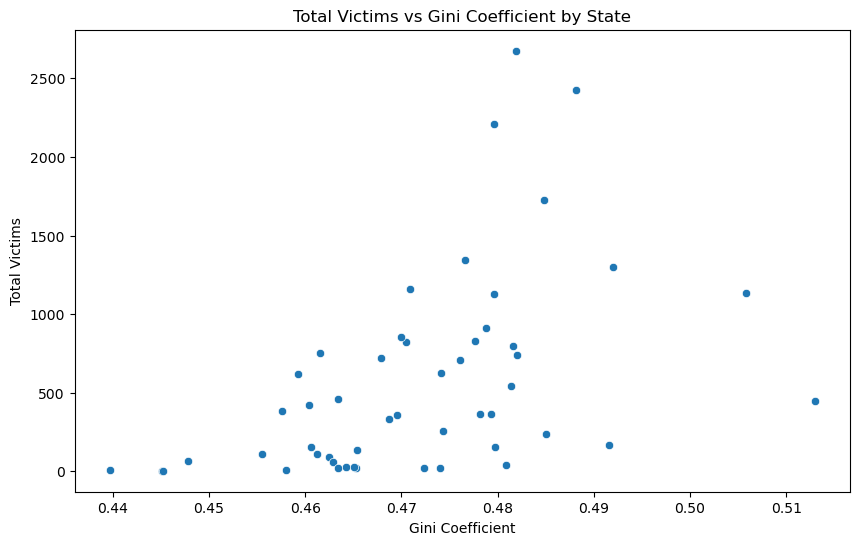

In [5]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_state_summary, x='gini_coefficient', y='total_victims')
plt.title('Total Victims vs Gini Coefficient by State')
plt.xlabel('Gini Coefficient')
plt.ylabel('Total Victims')
plt.show()

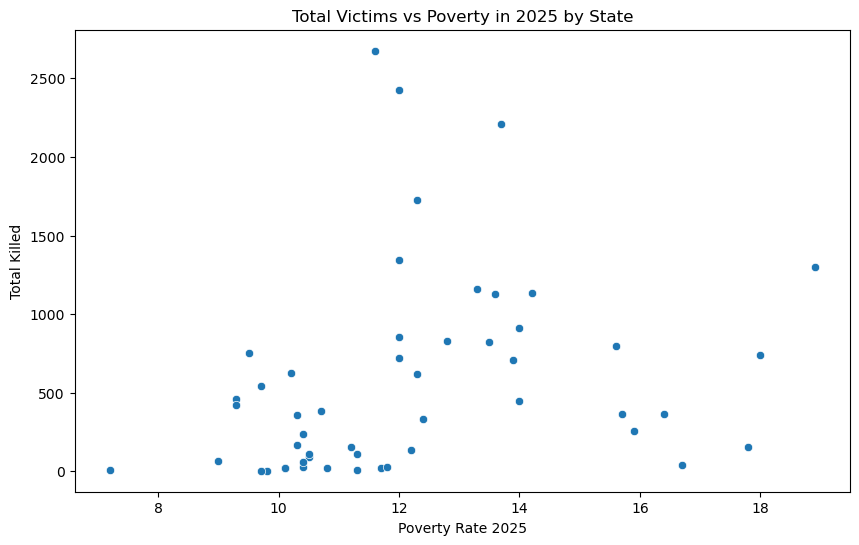

In [6]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_state_summary, x='poverty_rate_2025', y='total_victims')
plt.title('Total Victims vs Poverty in 2025 by State')
plt.xlabel('Poverty Rate 2025')
plt.ylabel('Total Killed')
plt.show()

In [7]:
# count of shootings by state
df_shooting_counts = df_merged['state'].value_counts().reset_index()
df_shooting_counts.columns = ['state', 'shooting_counts']
df_shooting_counts

,state,shooting_counts
0,Illinois,524
1,California,471
2,Texas,387
3,Florida,308
4,Pennsylvania,271
5,Louisiana,249
6,New York,231
7,Georgia,225
8,Ohio,219
9,Tennessee,177


<Axes: >

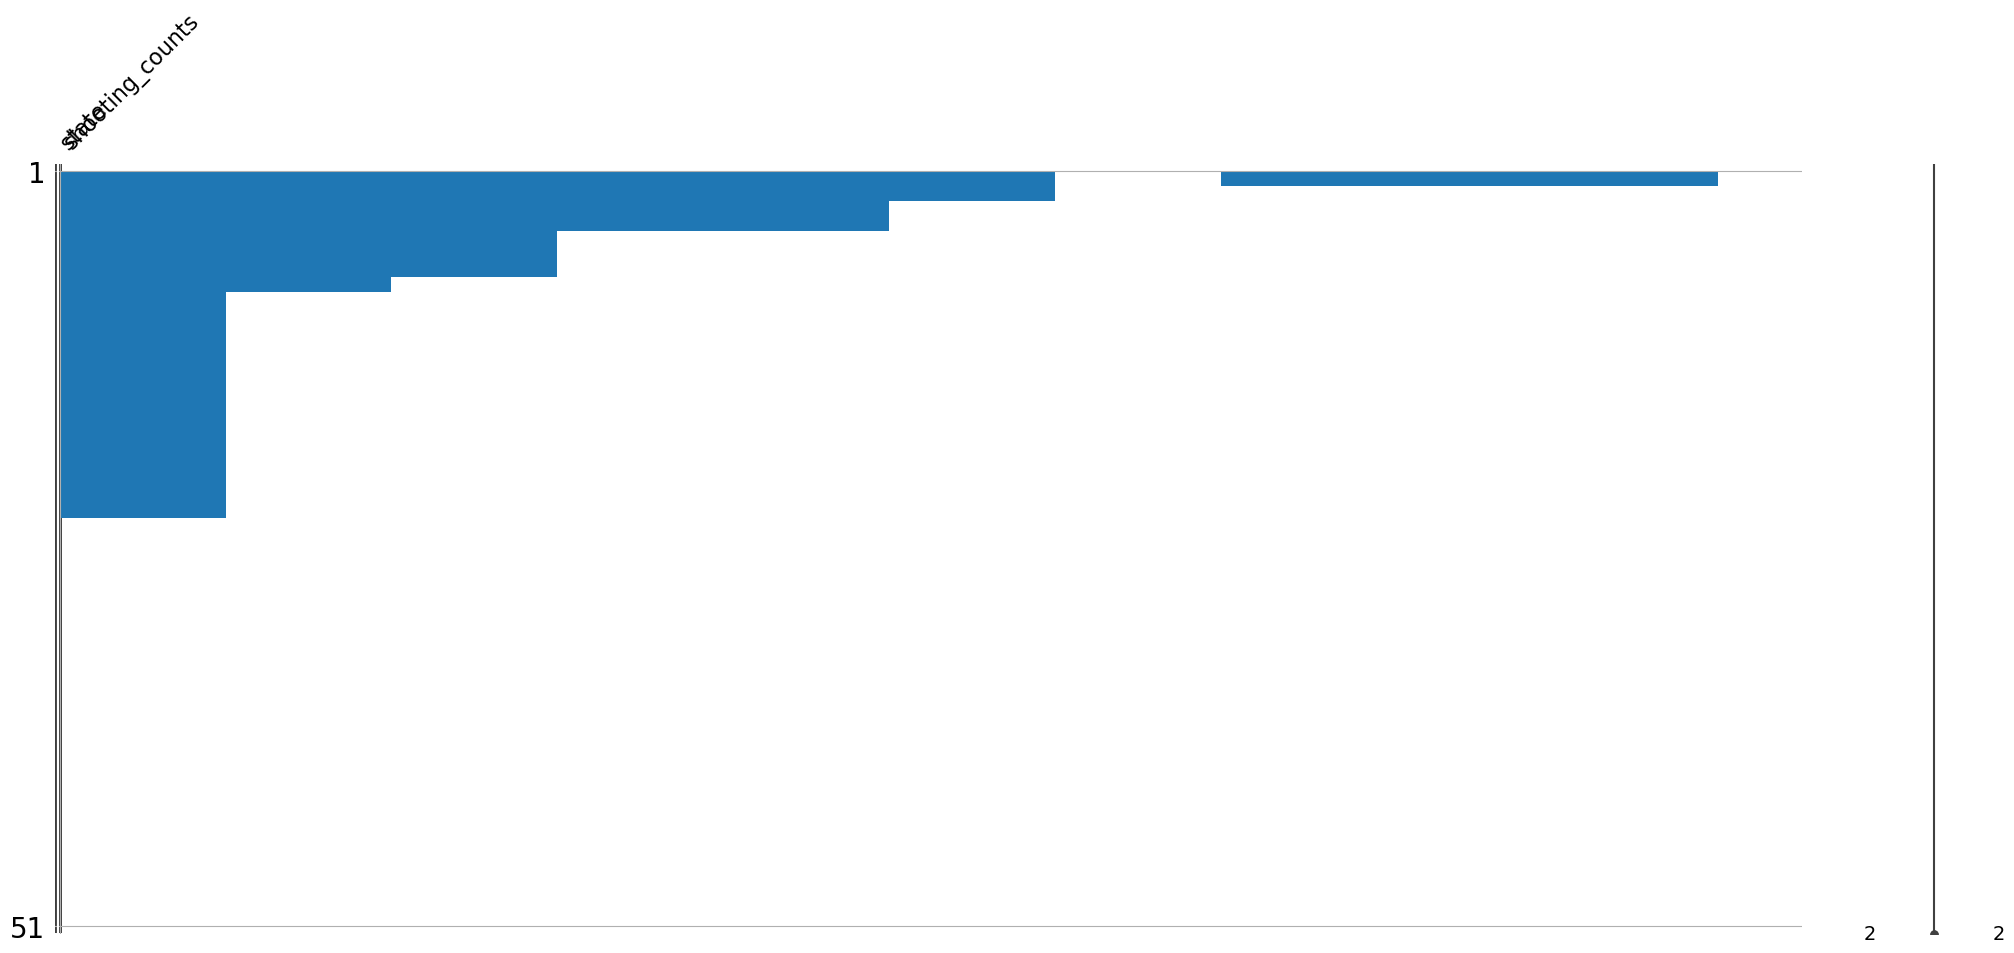

In [8]:
# Creating a dataframe for geodata
df_geo = df_shooting_counts[["state", "shooting_counts"]]

# Double checking if there are any missing values
msno.matrix(df_geo)

# Getting the geospatial files from geopandas and merging 
df_geo.shooting_counts.hist()


In [9]:
gdf = gpd.read_file(os.getcwd()+'/cb_2018_us_state_500k')


In [10]:
gdf = gdf.merge(df_shooting_counts,left_on='NAME',right_on='state')

#

<Axes: >

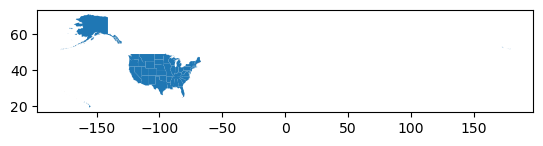

In [11]:
gdf.plot()

In [12]:
# Creating a copy of gdf for re-projecting
gdf.to_crs({'init':'epsg:2163'})

/opt/anaconda3/lib/python3.13/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry,state,shooting_counts
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((1109990.968 -1565553.473, 1111...",Mississippi,138
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((2154835.73 -692236.318, 215545...",North Carolina,170
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-268956.153 -936541.911, -268644.29 ...",Oklahoma,50
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((2098181.788 -490386.322, 20982...",Virginia,125
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((1506493.502 -601384.449, 1506500.488...",West Virginia,9
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((1079314.605 -1608998.456, 1079...",Louisiana,249
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((1376552.929 -187673.161, 13766...",Michigan,165
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((2420821.628 34539.216, 2421740...",Massachusetts,48
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-1357097.048 78008.665, -1356418.733...",Idaho,4
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((1997737.502 -1929546.629, 1997...",Florida,308


/opt/anaconda3/lib/python3.13/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


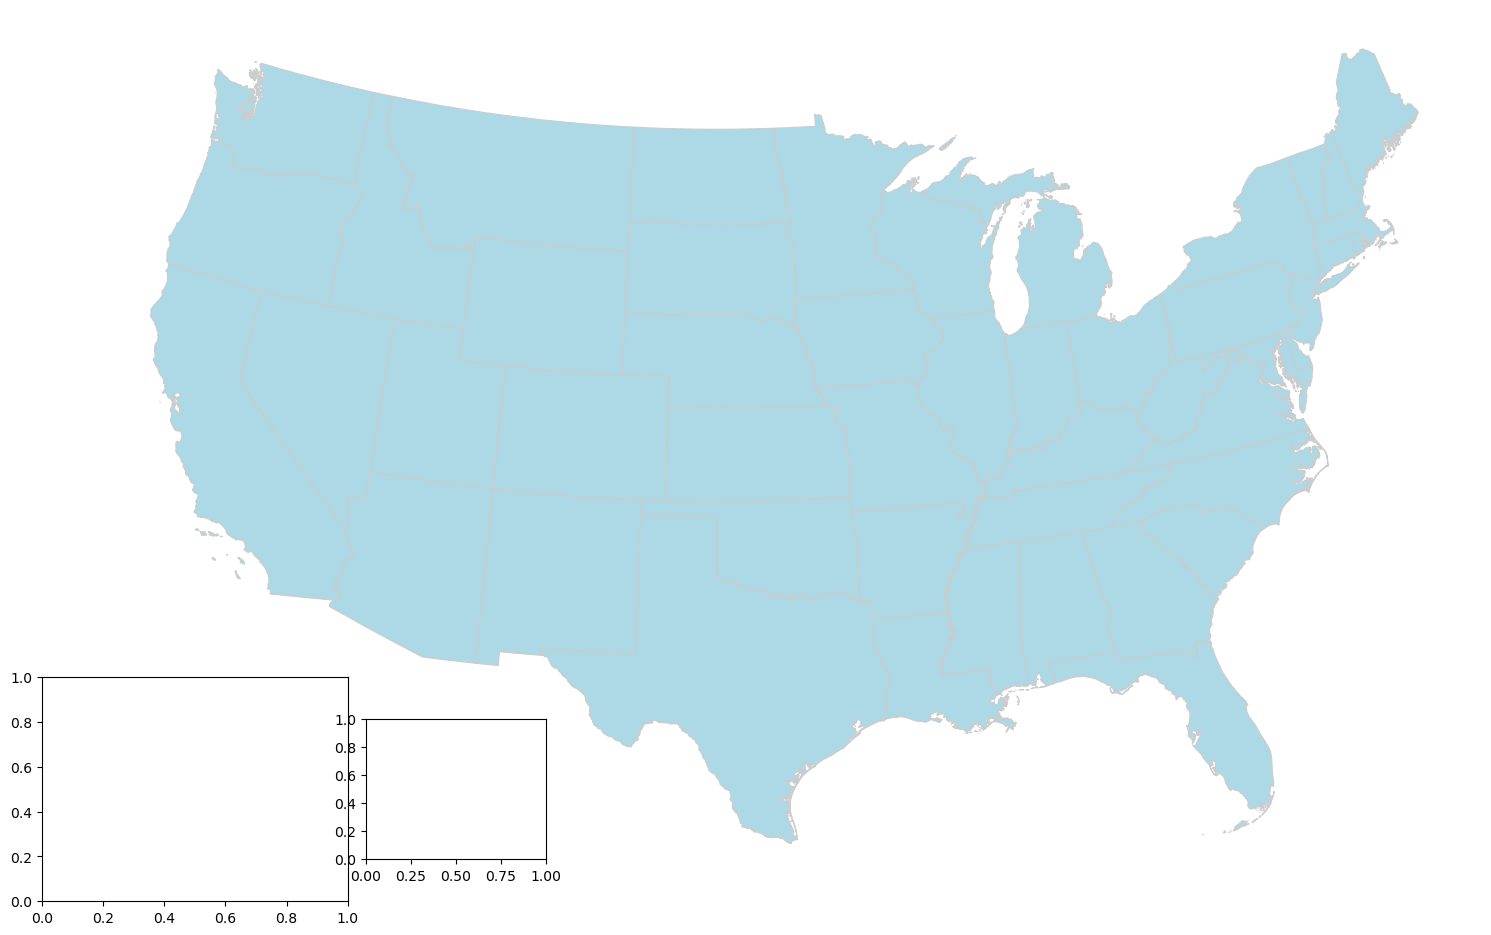

In [13]:

# Create a "copy" of gdf for re-projecting
visframe = gdf.to_crs({'init':'epsg:2163'})

# Create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box from the main map
ax.axis('off')


# Create map of all states except AK and HI in the main map axis
visframe[~visframe.state.isin(['Hawaii','Alaska'])].plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8')


# Add Alaska Axis (x, y, width, height)
akax = fig.add_axes([0.1, 0.17, 0.17, 0.16])   


# Add Hawaii Axis(x, y, width, height)
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   






In [14]:
# Apply this to the gdf to ensure all states are assigned colors by the same func

def makeColorColumn(gdf,variable,vmin,vmax):

    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

/opt/anaconda3/lib/python3.13/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/wc/048rx86x7bqbzmjn7nr46j_80000gn/T/ipykernel_6924/413883347.py:71: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')


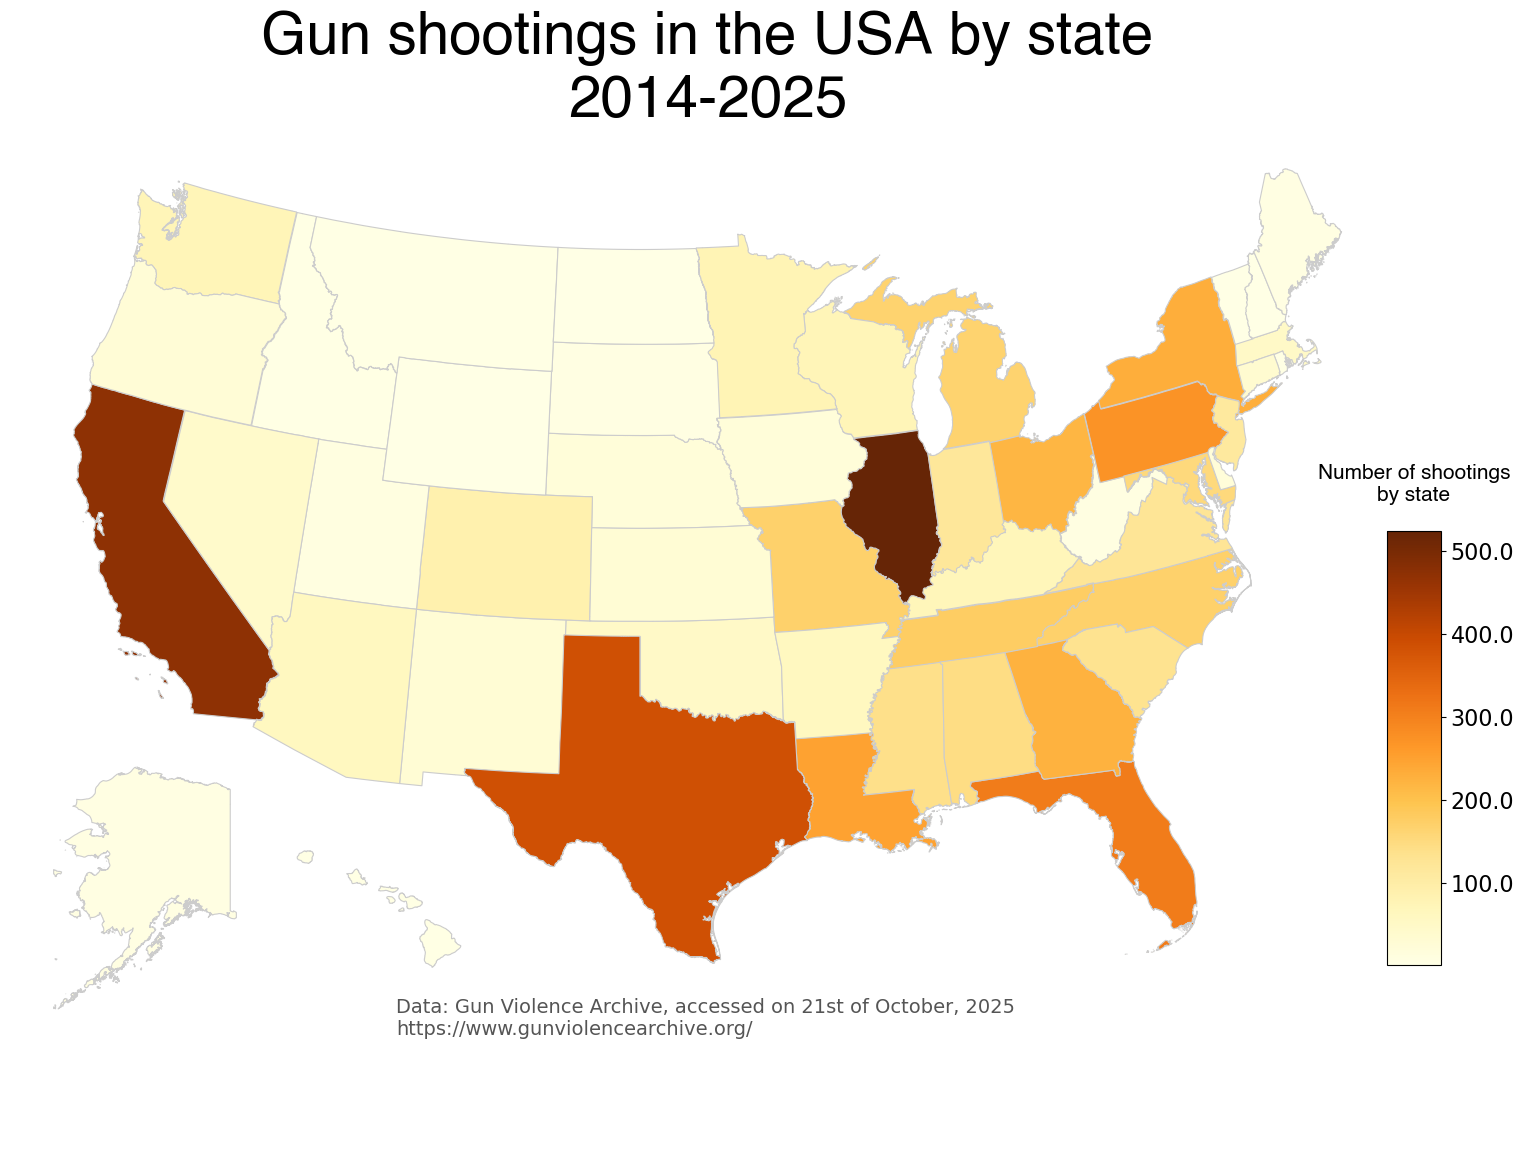

In [15]:

# **************************
# set the value column that will be visualised
variable = 'shooting_counts'

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf.shooting_counts.min(), gdf.shooting_counts.max() #math.ceil(gdf.shooting_counts.max())
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "YlOrBr"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163 for CONUS
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# set the font for the visualization to Helvetica
hfont = {'fontname':'Helvetica'}

# add a title and annotation
ax.set_title('Gun shootings in the USA by state\n2014-2025', **hfont, fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Number of shootings\nby state\n', **hfont, fontdict={'fontsize': '15', 'fontweight' : '0'})

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
# annotate the data source, date of access, and hyperlink
ax.annotate("Data: Gun Violence Archive, accessed on 21st of October, 2025\nhttps://www.gunviolencearchive.org/", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')


# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.state not in ['Alaska','Hawaii']:
        vf = visframe[visframe.state==row.state]
        c = gdf[gdf.state==row.state][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')

# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.state=='Alaska']
alaska_gdf.clip(polygon).plot(color=gdf[gdf.state=='Alaska'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.state=='Hawaii']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')

fig.savefig(os.getcwd()+'/gun_violence_2014-2025',dpi=400, bbox_inches="tight")
# bbox_inches="tight" keeps the vis from getting cut off at the edges in the saved png
# dip is "dots per inch" and controls image quality.  Many scientific journals have specifications for this
# https://stackoverflow.com/questions/16183462/saving-images-in-python-at-a-very-high-quality


# Credits to this blog: https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6